In [2]:
pip install torchbnn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import numpy as np
import matplotlib.pyplot as plt

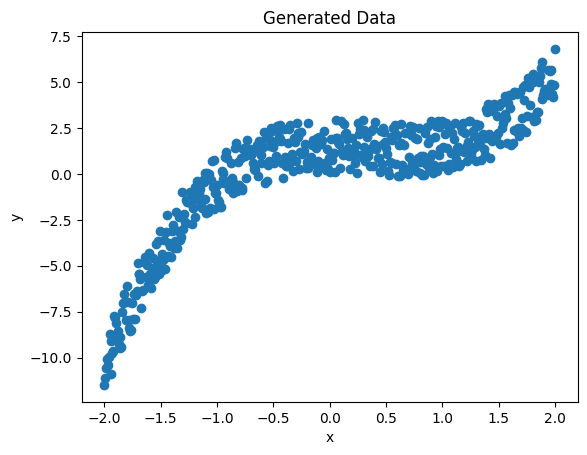

In [2]:
# 데이터 생성
x = torch.linspace(-2, 2, 500).unsqueeze(1)
y = x.pow(3) - x.pow(2) + 3 * torch.rand(x.size())

# 데이터 시각화
plt.scatter(x.numpy(), y.numpy())
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Data')
plt.show()


In [20]:
# BNN 모델 정의
class BayesianNN(nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()
        self.blinear1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=1, out_features=100)
        self.relu = nn.ReLU()
        self.blinear2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=100, out_features=1)

    def forward(self, x):
        x = self.blinear1(x)
        x = self.relu(x)
        x = self.blinear2(x)
        return x

model = BayesianNN()


In [28]:
# 손실 함수 및 옵티마이저 설정
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
# kl_weight = 0.01  # KL 손실의 가중치
kl_weight = 0.1

optimizer = optim.Adam(model.parameters(), lr=0.01)


In [29]:
# 모델 학습
num_epochs = 3000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # 순전파
    outputs = model(x)
    
    # 손실 계산
    mse = mse_loss(outputs, y)
    kl = kl_loss(model)
    loss = mse + kl_weight * kl
    
    # 역전파 및 최적화
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {mse.item():.4f}, KL Loss: {kl.item():.4f}')


Epoch [50/3000], MSE Loss: 0.7886, KL Loss: 1.1755
Epoch [100/3000], MSE Loss: 1.0495, KL Loss: 1.1970
Epoch [150/3000], MSE Loss: 0.7569, KL Loss: 1.2233
Epoch [200/3000], MSE Loss: 0.8799, KL Loss: 1.2336
Epoch [250/3000], MSE Loss: 0.8121, KL Loss: 1.2484
Epoch [300/3000], MSE Loss: 0.9835, KL Loss: 1.2572
Epoch [350/3000], MSE Loss: 0.7716, KL Loss: 1.2730
Epoch [400/3000], MSE Loss: 0.8467, KL Loss: 1.2883
Epoch [450/3000], MSE Loss: 0.8647, KL Loss: 1.2908
Epoch [500/3000], MSE Loss: 0.7594, KL Loss: 1.2892
Epoch [550/3000], MSE Loss: 0.7768, KL Loss: 1.2871
Epoch [600/3000], MSE Loss: 0.8139, KL Loss: 1.2980
Epoch [650/3000], MSE Loss: 0.8191, KL Loss: 1.2962
Epoch [700/3000], MSE Loss: 0.7708, KL Loss: 1.2867
Epoch [750/3000], MSE Loss: 0.7631, KL Loss: 1.2841
Epoch [800/3000], MSE Loss: 0.7712, KL Loss: 1.2679
Epoch [850/3000], MSE Loss: 0.7609, KL Loss: 1.2688
Epoch [900/3000], MSE Loss: 0.8082, KL Loss: 1.2722
Epoch [950/3000], MSE Loss: 0.7655, KL Loss: 1.2794
Epoch [1000/3

In [30]:
# 예측을 여러 번 수행하여 신뢰 구간 계산
# model.eval()
predictions_list = []

with torch.no_grad():
    for _ in range(10000):
        preds = model(x)
        predictions_list.append(preds.numpy())

# 예측 결과를 numpy 배열로 변환
predictions_np = np.array(predictions_list)  # shape: (100, N, 1)

# 평균과 신뢰 구간 계산
pred_mean = predictions_np.mean(axis=0).squeeze()  # (N,)
pred_std = predictions_np.std(axis=0).squeeze()
lower = pred_mean - 1.96 * pred_std
upper = pred_mean + 1.96 * pred_std


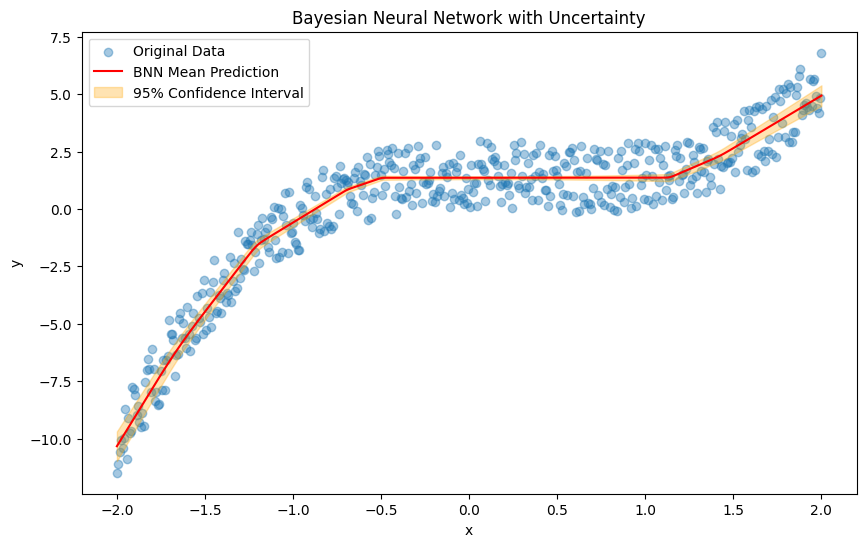

In [31]:
# 신뢰 구간 시각화
plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), label="Original Data", alpha=0.4)
plt.plot(x.numpy(), pred_mean, label="BNN Mean Prediction", color='red')
plt.fill_between(x.squeeze(), lower, upper, color='orange', alpha=0.3, label="95% Confidence Interval")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Bayesian Neural Network with Uncertainty")
plt.show()


## GPR 테스트

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# 데이터 (BNN과 동일하게 사용)
X = x.numpy()  # (500, 1)
Y = y.numpy().ravel()  # (500,)

# 커널 정의: RBF + WhiteKernel (잡음)
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

# GPR 모델 정의 및 학습
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr.fit(X, Y)

# 예측
y_pred, std_pred = gpr.predict(X, return_std=True)
lower = y_pred - 1.96 * std_pred
upper = y_pred + 1.96 * std_pred


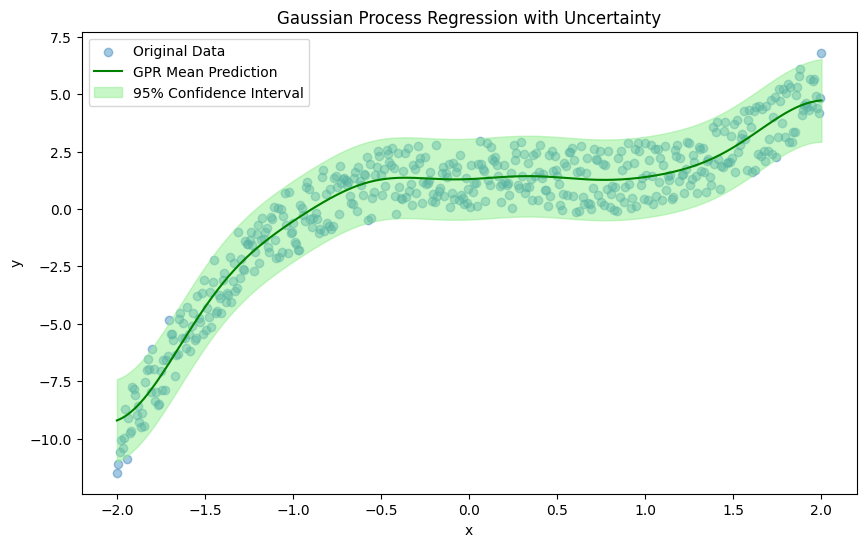

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Original Data', alpha=0.4)
plt.plot(X, y_pred, label='GPR Mean Prediction', color='green')
plt.fill_between(X.squeeze(), lower, upper, color='lightgreen', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Process Regression with Uncertainty')
plt.legend()
plt.show()


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# ✅ 시드 설정 (재현성)
torch.manual_seed(0)
np.random.seed(0)

# ✅ 데이터 (GPR과 동일)
X = x.numpy()  # (500, 1)
Y = y.numpy().ravel()  # (500,)
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

# ✅ MC Dropout 모델 정의
class MCDropoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.dropout = nn.Dropout(p=0.5)  # 작은 dropout
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # dropout 적용
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # inference 시에도 적용
        return self.fc3(x)

model = MCDropoutNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# ✅ 학습
model.train()
for epoch in range(500):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, Y_tensor)
    loss.backward()
    optimizer.step()


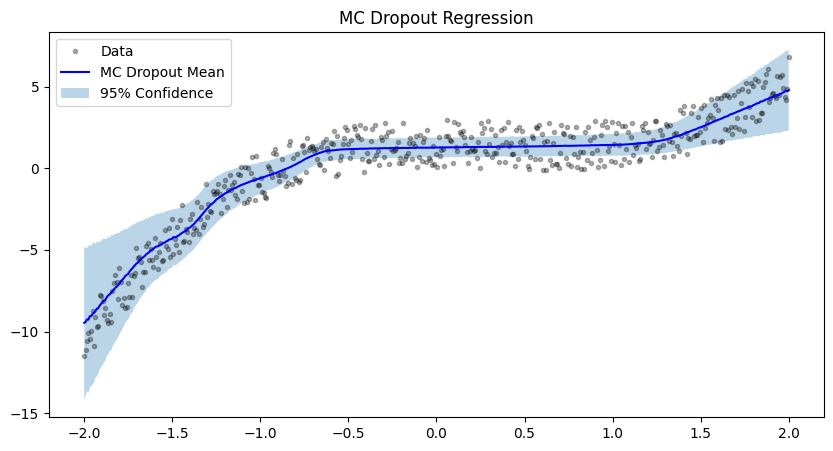

In [55]:


# ✅ MC Dropout 예측 함수
def mc_predict(model, x_tensor, num_samples=5000):
    model.train()  # dropout 켜기
    preds = [model(x_tensor).detach().numpy() for _ in range(num_samples)]
    preds = np.stack(preds, axis=0)  # (num_samples, N, 1)
    mean = preds.mean(axis=0).squeeze()
    std = preds.std(axis=0).squeeze()
    return mean, std

# ✅ 예측
mean_pred, std_pred = mc_predict(model, X_tensor, num_samples=5000)
lower = mean_pred - 1.96 * std_pred
upper = mean_pred + 1.96 * std_pred

# ✅ 시각화 (GPR과 동일하게)
plt.figure(figsize=(10, 5))
plt.plot(X, Y, 'k.', alpha=0.3, label='Data')
plt.plot(X, mean_pred, 'b-', label='MC Dropout Mean')
plt.fill_between(X.ravel(), lower, upper, alpha=0.3, label='95% Confidence')
plt.legend()
plt.title("MC Dropout Regression")
plt.show()


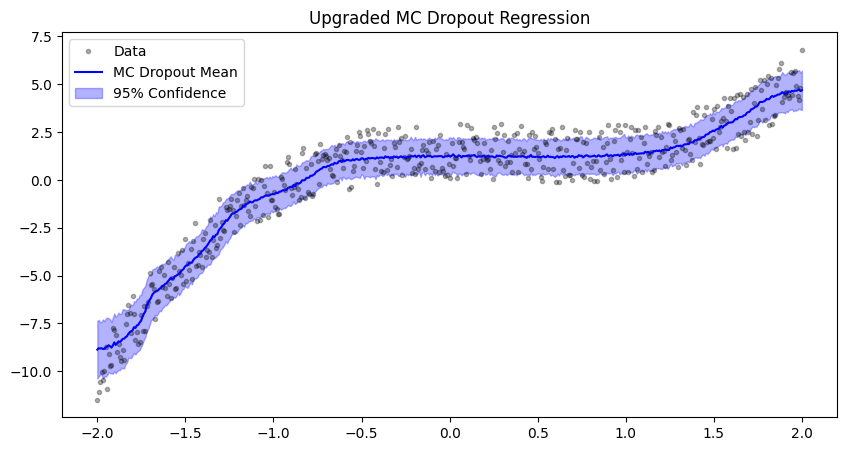

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# ✅ 데이터 준비
X = x.numpy()
Y = y.numpy().ravel()
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

# ✅ 향상된 MC Dropout 모델 정의
class DeepMCDropoutNet(nn.Module):
    def __init__(self, p=0.3):
        super().__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = torch.tanh(self.dropout(self.fc1(x)))  # Tanh로 smooth하게
        x = torch.tanh(self.dropout(self.fc2(x)))
        x = torch.tanh(self.dropout(self.fc3(x)))
        return self.fc4(x)

# ✅ 모델 초기화
model = DeepMCDropoutNet(p=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# ✅ 학습
model.train()
for epoch in range(3000):  # 충분히 학습
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = loss_fn(output, Y_tensor)
    loss.backward()
    optimizer.step()

# ✅ MC Dropout 예측 함수 (T=200)
def mc_predict(model, x_tensor, num_samples=200):
    model.train()  # Dropout 유지
    preds = [model(x_tensor).detach().numpy() for _ in range(num_samples)]
    preds = np.stack(preds, axis=0)
    mean = preds.mean(axis=0).squeeze()
    std = preds.std(axis=0).squeeze()
    return mean, std

# ✅ 예측
mean_pred, std_pred = mc_predict(model, X_tensor)
lower = mean_pred - 1.96 * std_pred
upper = mean_pred + 1.96 * std_pred

# ✅ 시각화
plt.figure(figsize=(10, 5))
plt.plot(X, Y, 'k.', alpha=0.3, label='Data')
plt.plot(X, mean_pred, 'b-', label='MC Dropout Mean')
plt.fill_between(X.ravel(), lower, upper, alpha=0.3, color='blue', label='95% Confidence')
plt.legend()
plt.title("Upgraded MC Dropout Regression")
plt.show()
